# Analysis

In [66]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # second gpu


# import jax
# # again, this only works on startup!
# from jax import config
# config.update("jax_enable_x64", True)

In [67]:
import autoroot
import xarray as xr
from somax._src.constants import GRAVITY

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper Functions

In [68]:
import glob, os
from dateutil.parser import parse
from omegaconf import DictConfig
from jaxtyping import Array

def ssh_to_streamfn(ssh: Array, f0: float = 1e-5, g: float = GRAVITY) -> Array:
    """Calculates the ssh to stream function

    Eq:
        η = (g/f₀) Ψ

    Args:
        ssh (Array): the sea surface height [m]
        f0 (Array|float): the coriolis parameter
        g (float): the acceleration due to gravity

    Returns:
        psi (Array): the stream function
    """
    return (g / f0) * ssh

def streamfn_to_ssh(psi: Array, f0: float = 9.4e-05, g: float = GRAVITY) -> Array:
    """Calculates the stream function to ssh

    Eq:
        Ψ = (f₀/g) η

    Args:
        psi (Array): the stream function
        f0 (Array|float): the coriolis parameter
        g (float): the acceleration due to gravity

    Returns:
        ssh (Array): the sea surface height [m]
    """
    return (f0 / g) * psi

def get_list_filenames(data_path: str="./", ext: str="*"):
    """
    Loads a list of file names within a directory.

    Args:
        data_path (str, optional): The directory path to search for files. Defaults to "./".
        ext (str, optional): The file extension to filter the search. Defaults to "*".

    Returns:
        List[str]: A sorted list of file names matching the given extension within the directory.
    """
    pattern = f"*{ext}"
    return sorted(glob.glob(os.path.join(data_path, "**", pattern), recursive=True))

def get_files(datasets_spec: DictConfig, ext=".nc"):
    """
    Get a list of filenames based on the provided datasets specification.

    Args:
        datasets_spec (DictConfig): The datasets specification containing the path and extension.
        ext (str, optional): The file extension to filter the search. Defaults to ".nc".

    Returns:
        List[str]: A list of filenames.

    """
    data_path = datasets_spec.data_path
    return get_list_filenames(data_path=data_path, ext=ext)

## Load Data

In [69]:
save_dir = "/pool/usuarios/juanjohn/data/qg_runs"

# get list of all files in directory
list_of_files = get_list_filenames(save_dir, ".nc")
print(f"All Files: {len(list_of_files)}")

list_of_files[0]

All Files: 24


'/pool/usuarios/juanjohn/data/qg_runs/soln_001y_r256_d0.0_wenoz_pts3.nc'

In [80]:
# filter for methods
# "soln_{year}y_r{resolution}_d{diffusivity}_{method}_pts{num_pts}.nc"
method = "wenoz"
num_pts = "3"
resolution = "256"
diffusivity = "d0.0"
filter_strings = [method, num_pts, resolution, diffusivity]

criteria = lambda x: all(istring in x for istring in filter_strings)

list_of_files = list(filter(criteria, list_of_files))

print(f"Criteria Files: {len(list_of_files)}")

Criteria Files: 24


In [81]:
list_of_files

['/pool/usuarios/juanjohn/data/qg_runs/soln_001y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_002y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_003y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_004y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_005y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_006y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_007y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_008y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_009y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_010y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_011y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_012y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn/data/qg_runs/soln_013y_r256_d0.0_wenoz_pts3.nc',
 '/pool/usuarios/juanjohn

In [82]:
def clean_ssh_names(da):

    da.attrs["long_name"] = "Sea Surface Height"
    da.attrs["short_name"] = "sea_surface_height"
    da.attrs["units"] = "meters"

    return da

def clean_q_names(da):

    da.attrs["long_name"] = "Potential Vorticity"
    da.attrs["short_name"] = "potential_vorticity"
    da.attrs["units"] = "meters^2 / second"

    return da

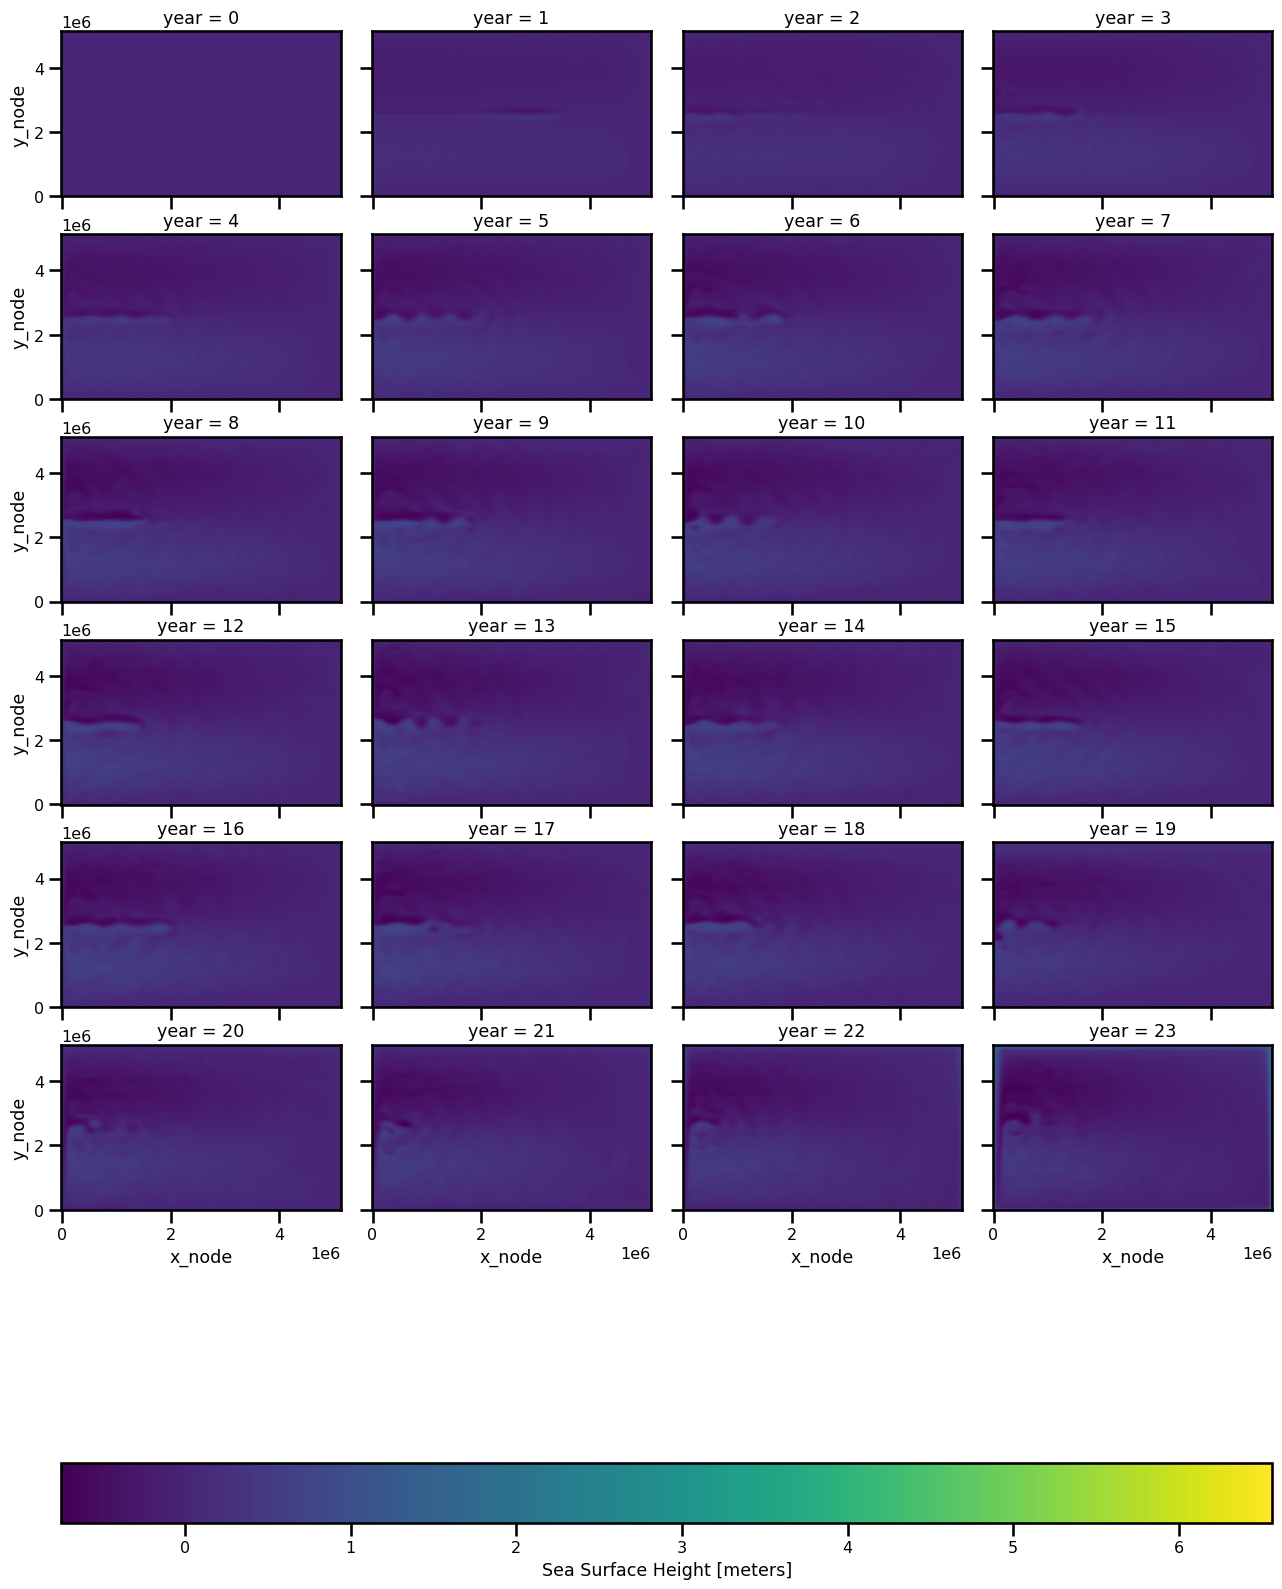

In [83]:
def preprocess(ds):
    # create new dimension
    ds["time"] = ds["time"].assign_coords({"time": "year"})
    ds = ds.expand_dims(["year", "resolution", "diffusivity", "num_pts", "method"])
    ds["psi"] = streamfn_to_ssh(ds["psi"]).copy()
    ds = ds.rename({"psi": "ssh"})
    ds["ssh"] = clean_ssh_names(ds.ssh)
    ds = ds["ssh"]
    return ds

with xr.open_mfdataset(list_of_files, preprocess=preprocess, combine="by_coords", engine="netcdf4") as ds:
    variable = "ssh"
    z = 0

    vmin, vmax = ds[variable].min().values, ds[variable].max().values
    # vmin -= - 0.02 * vmin
    # vmax += 0.02 * vmax
    cmap = "viridis"
    
    fig = ds[variable].squeeze().isel(year=slice(None,None,1), z=z).squeeze().plot.pcolormesh(
        x="x_node", y="y_node",
        col="year", col_wrap=4, cmap=cmap,
        vmin=vmin, vmax=vmax,
        # usual xarray stuff
        cbar_kwargs={
            "orientation": "horizontal", 
            # "shrink": 0.8, "aspect": 40, 
            # "fraction": 0.027, "pad": -.2, "aspect": 40,
        },
        robust=False,
    )
    # fig.cbar.set_label(label=f'Predicted Temperature [°C]', size=20, weight='bold')
    # plt.tight_layout()
    # plt.suptitle(f"{variable.upper()}")
    plt.show()

## Plot

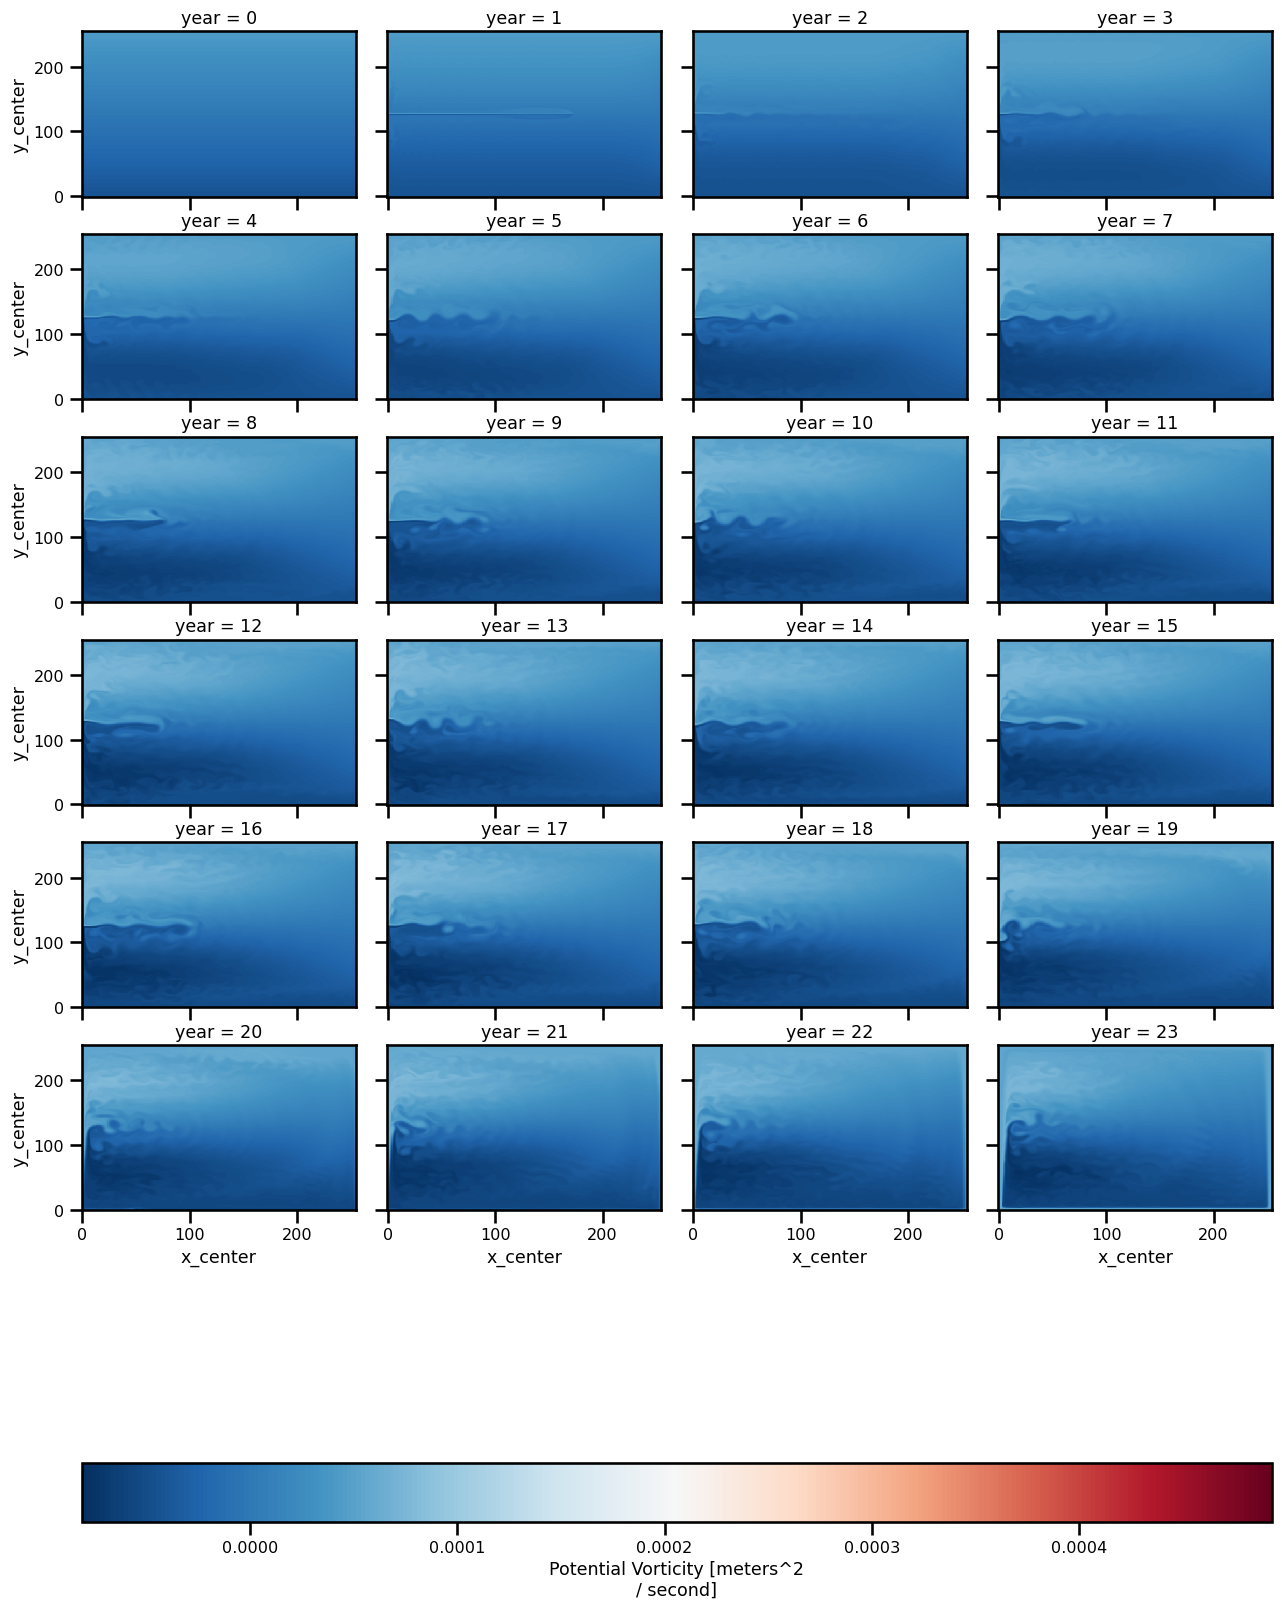

In [84]:
def preprocess(ds):
    # create new dimension
    ds["time"] = ds["time"].assign_coords({"time": "year"})
    ds = ds.expand_dims(["year", "resolution", "diffusivity", "num_pts", "method"])
    ds = ds["q"]
    ds = clean_q_names(ds)
    
    return ds

with xr.open_mfdataset(list_of_files, preprocess=preprocess, combine="by_coords", engine="netcdf4") as ds:
    
    variable = "q"
    z = 0

    vmin, vmax = ds[variable].min().values, ds[variable].max().values    # vmin -= - 0.02 * vmin
    # vmax += 0.02 * vmax
    cmap = "RdBu_r"
    
    fig = ds[variable].squeeze().isel(year=slice(None,None,1), z=z).squeeze().plot.pcolormesh(
        x="x_center", y="y_center",
        col="year", col_wrap=4, cmap=cmap,
        vmin=vmin, vmax=vmax,
        # usual xarray stuff
        cbar_kwargs={
            "orientation": "horizontal", 
            # "shrink": 0.8, "aspect": 40, 
            # "fraction": 0.027, "pad": -.2, "aspect": 40,
        },
        robust=False,
    )
    # fig.cbar.set_label(label=f'Predicted Temperature [°C]', size=20, weight='bold')
    # plt.tight_layout()
    # plt.suptitle(f"{variable.upper()}")
    plt.show()

In [65]:

try:
    del ds
except:
    pass
ds = xr.open_mfdataset(list_of_files, preprocess=preprocess, combine="by_coords", engine="netcdf4").compute()
ds

<xarray.Dataset> Size: 37MB
Dimensions:      (year: 24, resolution: 1, diffusivity: 1, num_pts: 1,
                  method: 1, z: 3, x_center: 255, y_center: 255)
Coordinates:
  * year         (year) int64 192B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * diffusivity  (diffusivity) float64 8B 0.0
  * method       (method) <U5 20B 'wenoz'
  * num_pts      (num_pts) int64 8B 3
  * resolution   (resolution) int64 8B 256
    time         (year) float64 192B 0.0 51.54 48.45 41.9 ... 54.83 67.81 167.5
Dimensions without coordinates: z, x_center, y_center
Data variables:
    q            (year, resolution, diffusivity, num_pts, method, z, x_center, y_center) float64 37MB ...

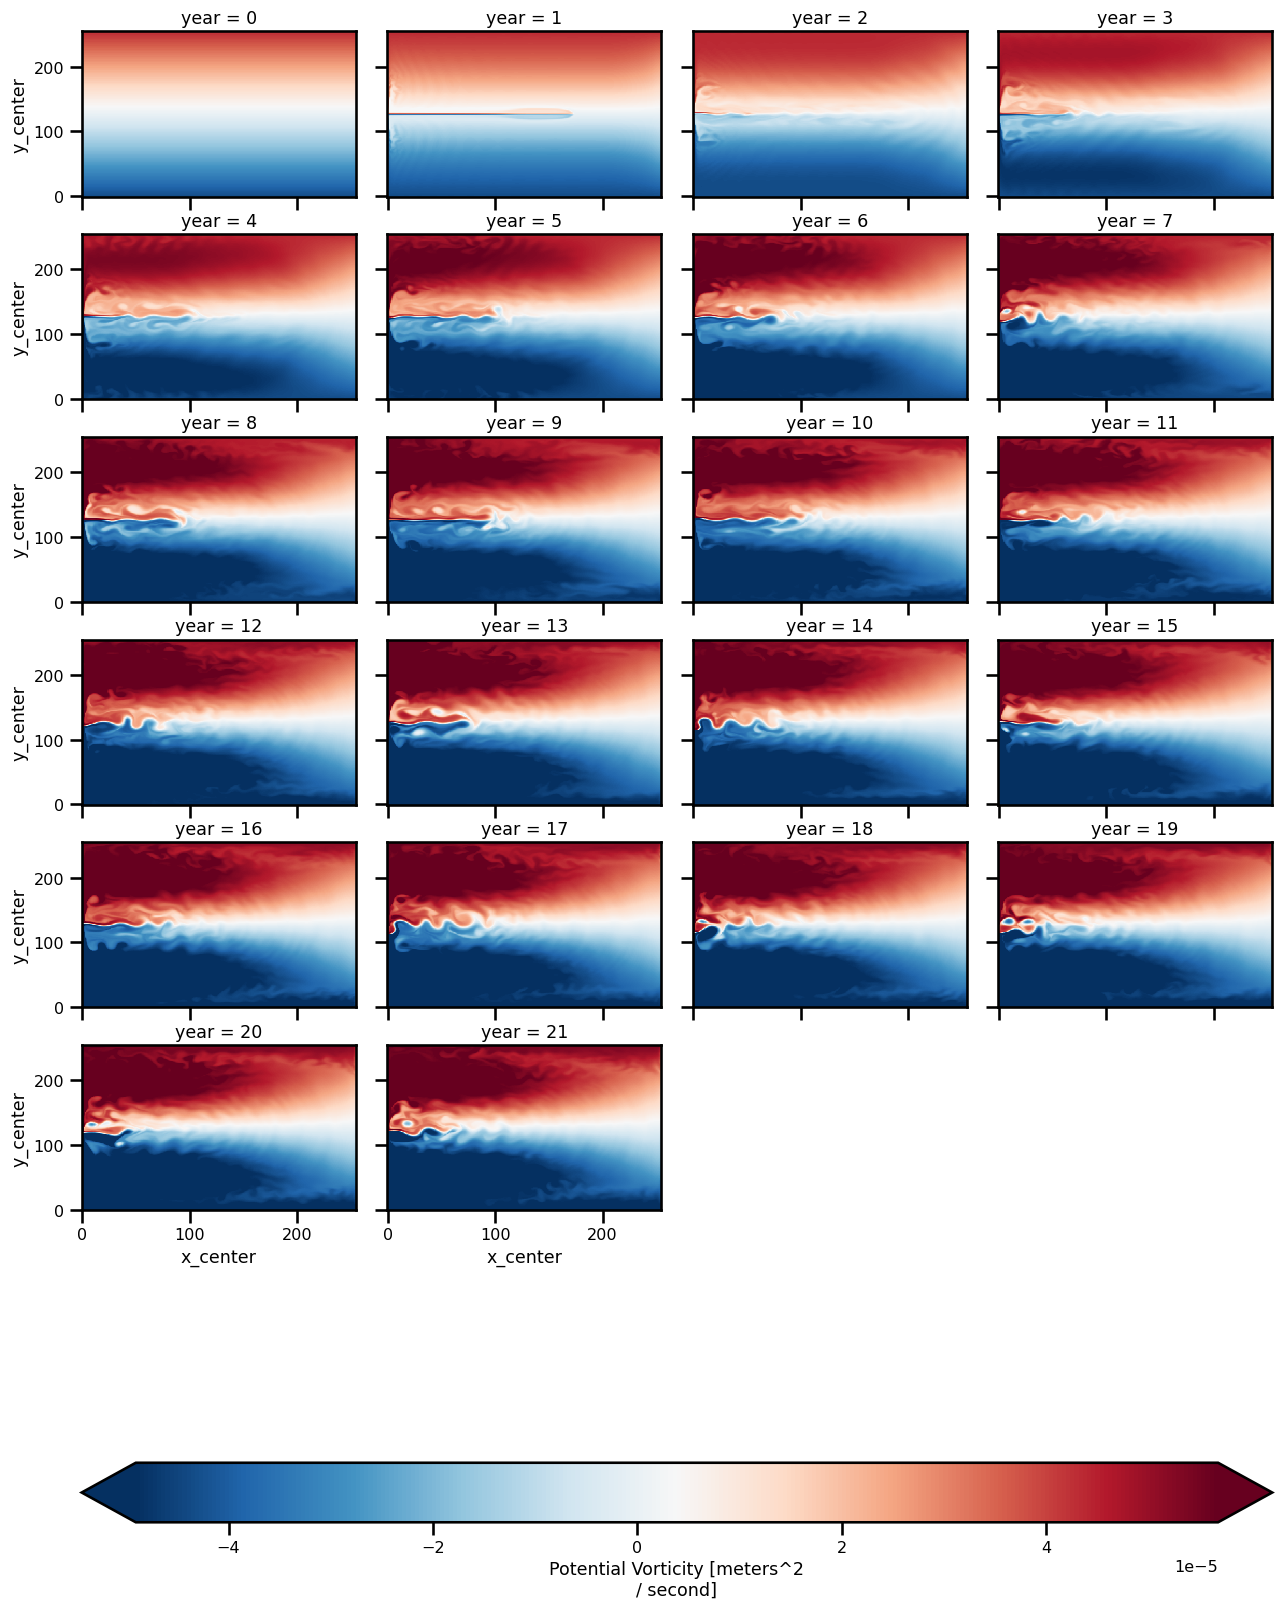

In [11]:
variable = "q"
z = 0

vmin, vmax = ds[variable].quantile(q=0.05).values, ds[variable].quantile(q=0.975).values
# vmin -= - 0.02 * vmin
# vmax += 0.02 * vmax
cmap = "RdBu_r"

fig = ds[variable].squeeze().isel(year=slice(None,None,1), z=z).squeeze().plot.pcolormesh(
    x="x_center", y="y_center",
    col="year", col_wrap=4, cmap=cmap,
    vmin=vmin, vmax=vmax,
    # usual xarray stuff
    cbar_kwargs={
        "orientation": "horizontal", 
        # "shrink": 0.8, "aspect": 40, 
        # "fraction": 0.027, "pad": -.2, "aspect": 40,
    },
    robust=False,
)
# fig.cbar.set_label(label=f'Predicted Temperature [°C]', size=20, weight='bold')
# plt.tight_layout()
# plt.suptitle(f"{variable.upper()}")
plt.show()

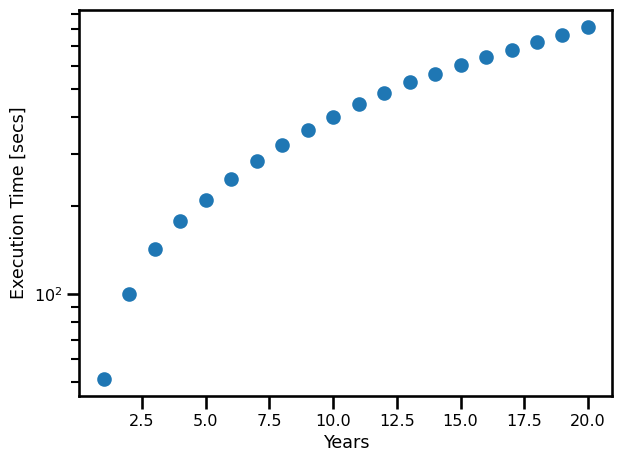

In [78]:
fig, ax = plt.subplots()

ax.scatter(ds.year.values, ds.time.cumsum().values)
ax.set(
    xlabel="Years",
    ylabel="Execution Time [secs]",
    yscale="log"
)
plt.tight_layout()
plt.show()

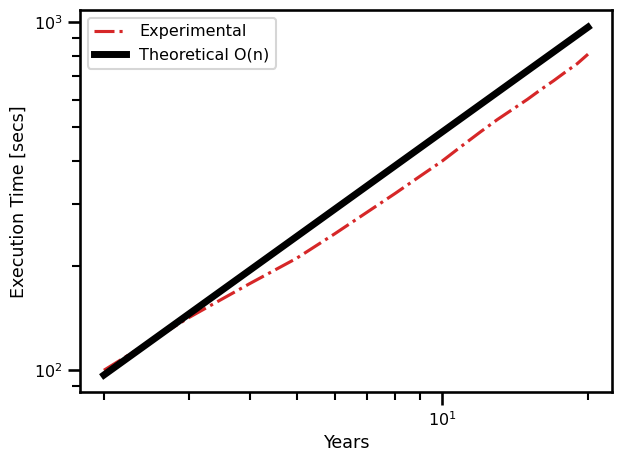

In [79]:
fig, ax = plt.subplots()

tmin = ds.time.values[1]
ax.loglog(ds.year.values[1:], ds.time.cumsum().values[1:], label="Experimental", color="tab:red", linestyle='-.')
ax.loglog(ds.year.values[1:], tmin * ds.year.values[1:] , label='Theoretical O(n)', linewidth=5, color="black")
ax.set(
    xlabel="Years",
    ylabel="Execution Time [secs]",
)
plt.legend()
plt.tight_layout()
plt.show()